In [44]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../../")

import numpy
import pylab
from ctm.ctmLink import CTMLink
from ctm.variableLaneFDLink import VariableLaneFDLink
from ctm.triangularFundamentalDiagram import TriangularFundamentalDiagram
import ctm.capacityDropMerge
from continuousSingleCommodity.originNode import OriginNode
from continuousSingleCommodity.destinationNode import DestinationNode
from continuousSingleCommodity.mergeNode import MergeNode
from continuousSingleCommodity.oneToOneNode import OneToOneNode
from continuousSingleCommodity.divergeNode import DivergeNode

import simulationengine.simulationRunner as simulationRunner

In [45]:
class LinkController:
    def __init__(self, link):
        self.link = link
        self.fd = TriangularFundamentalDiagram(vf=30.0, w=6.0, kj=0.1)
        self.fd2 = TriangularFundamentalDiagram(vf=30.0, w=6.0, kj=1.25*0.1)
    
    def start(self, time_step, total_time):
        pass

    def run_step(self, t):
        if t==40:
            self.link.set_switch(t, self.fd2, self.link.num_lanes)
        elif t==130:
            self.link.set_switch(t, self.fd, self.link.num_lanes)

0.1


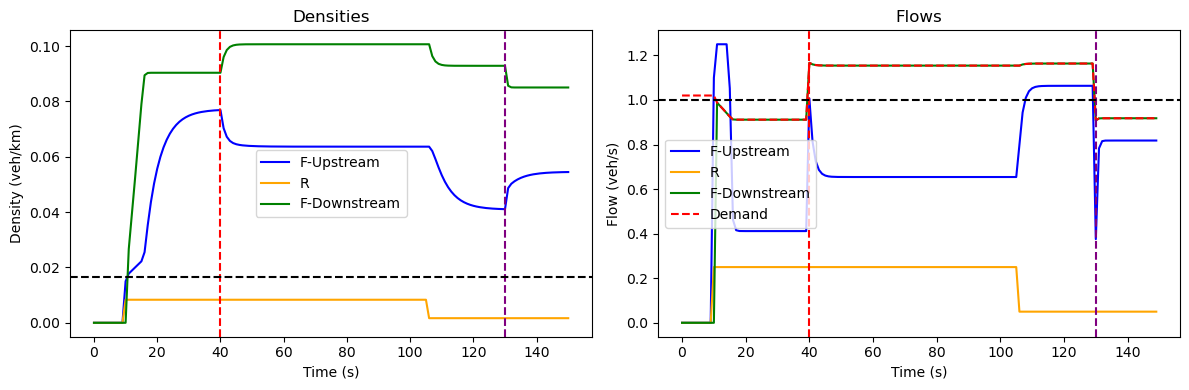

In [46]:
priorities = [0.25, 0.75]

dem_1 = [1.4 for _ in range(12)]

for i in range(0,3):
    dem_1[i] = 1.35

dem_2 = [0.25 for _ in range(12)]
for p in range(8,12):
    dem_2[p] = 0.05
    dem_1[p] = 0.3

fd = TriangularFundamentalDiagram(vf=30.0, w=6.0, kj=0.1)
fd2 = TriangularFundamentalDiagram(vf=30.0, w=6.0, kj=1.25*0.1)
inbound_link_1 = CTMLink(link_id=1,length=300, kj=0.1, lm=30, fundamental_diagram=fd, num_lanes = 3)
inbound_link_2 = CTMLink(link_id=2, length=300, lm=30, fundamental_diagram=fd, num_lanes = 1)
outbound_link = VariableLaneFDLink(link_id=3, length=300, lm=30, fundamental_diagram=fd, num_lanes = 2, alpha_d=0.1)

origin_node_1 = OriginNode(1, inbound_link_1, dem_1)
origin_node_2 = OriginNode(2, inbound_link_2, dem_2)
#merge_node = MergeNode(3, [inbound_link_1, inbound_link_2], outbound_link, priorities)
merge_node = ctm.capacityDropMerge.CapacityDropMergeNode(3, inbound_link_1, inbound_link_2, outbound_link, theta_l=0.3, theta_r=0.1)

destination_node = DestinationNode(4, outbound_link)

links = [inbound_link_1, inbound_link_2, outbound_link]
nodes = [origin_node_1, origin_node_2, merge_node, destination_node]

controller = LinkController(outbound_link)


sim = simulationRunner.SimulationRunner(links = links, nodes = nodes, time_step = 1.0, total_time=150)
sim.general_purpose_objects = [controller]
sim.run()

f, axs = pylab.subplots(1, 2, figsize=(12, 4))

axs[0].set_title("Densities")
axs[1].set_title("Flows")

axs[0].plot(inbound_link_1.rho[inbound_link_1.num_cells-1,:], label="F-Upstream", color='blue')
axs[0].plot(inbound_link_2.rho[inbound_link_2.num_cells-1,:], label="R", color='orange')
axs[0].plot(outbound_link.rho[0,:], label="F-Downstream", color='green')

axs[1].plot(inbound_link_1.qs[inbound_link_1.num_cells-1,:], label="F-Upstream", color='blue')
axs[1].plot(inbound_link_2.qs[inbound_link_2.num_cells-1,:], label="R", color='orange')
axs[1].plot(outbound_link.qs[0,:], label="F-Downstream", color='green')
axs[1].plot(outbound_link.first_cell_demands, label="Demand", color='red', linestyle='--')

axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Density (veh/km)")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Flow (veh/s)")

axs[0].legend()
axs[1].legend()

axs[0].axvline(40, color='red', linestyle='--', label='Switch Time')
axs[1].axvline(40, color='red', linestyle='--', label='Switch Time')

axs[0].axvline(130, color='purple', linestyle='--', label='Switch Time')
axs[1].axvline(130, color='purple', linestyle='--', label='Switch Time')

axs[0].axhline(outbound_link.fundamental_diagram.get_critical_density(), color='black', linestyle='--', label='Critical Density')
axs[1].axhline(outbound_link.fundamental_diagram.get_capacity()*outbound_link.num_lanes, color='black', linestyle='--', label='Capacity')

pylab.tight_layout()
pylab.show()

In [ ]:
upstream= [121.2304423470158, 131.3879445175207, 135.36620840292113, 147.45343204965957, 121.96855327856917, 136.16250478700508, 170.86073021737548, 138.27887569206703, 156.53101265303403, 184.09347202749888, 190.074076876655, 135.50197445882515, 225.05358652631566, 194.52991745353805, 158.90927262654236, 184.29717564341465, 204.76265926366142, 175.2389901908838, 184.27778049257103, 184.29717564341465, 195.6074980569125, 176.10322413497852, 155.90927262654236, 165.06443383329128, 160.88987747569874, 179.40390350511237, 180.52027441017404, 174.3457180525815, 174.3457180525815, 158.05479078992727, 153.9772101865528, 165.09358109161448, 171.1905568458326, 159.01600048824002, 139.64749262221136, 166.66677870893935, 155.4728272005032, 180.78314961400105, 169.6279884072521, 175.80254476484467, 142.2400853903798, 165.6085932564085, 152.39524659712873, 156.43403689881595, 153.33706114460438, 115.61944056338409, 149.3564562954415, 143.16250478700533, 135.22069023953617, 142.29827084291065, 128.94915812772558, 116.8715775243511]
ramp_counts= [6, 7, 4, 7, 7, 4, 8, 5, 5, 5, 8, 7, 10, 8, 10, 8, 8, 17, 9, 10, 11, 11, 14, 17, 16, 23, 15, 21, 25, 27, 23, 25, 17, 31, 19, 11, 20, 29, 12, 25, 20, 17, 24, 24, 9, 16, 10, 15, 18, 19, 16, 11]
up_density= [0.026694962949450337, 0.03106063384729535, 0.03538432767364516, 0.03625466363198721, 0.029289178244435964, 0.03448320802912783, 0.03688992515428742, 0.02916884372261033, 0.03720055931984489, 0.04808955144748759, 0.041806903848452356, 0.03325186558623812, 0.05728265020384717, 0.07016418084724625, 0.05731903183371273, 0.05391884150344934, 0.06893843634804683, 0.060400186078761936, 0.0670354482509307, 0.0742947760580191, 0.08494869374961996, 0.08299253769774935, 0.07720802368512794, 0.07168936529266301, 0.0654682833979379, 0.05337593354173561, 0.061564365707671466, 0.06029104452524612, 0.08530969940014739, 0.11055783326946088, 0.09371641634115532, 0.07492723860847415, 0.09245988815578061, 0.08398320692688671, 0.07372387921187415, 0.06328824629534537, 0.05471361689825556, 0.05576585766984456, 0.049919775450852376, 0.05166324633938163, 0.048598880921281985, 0.05405876924520108, 0.07044123068674286, 0.07768936677655178, 0.0466763075274318, 0.029429105569177598, 0.040486007650841524, 0.03805970272688723, 0.037721082178959205, 0.034469216088972875, 0.0348833955323963, 0.028357276581783792]

upstream = [el/120 for el in upstream]  #demand in steps of 2 minutes
ramp_counts = [el/120 for el in ramp_counts]

def get_base_fd():
    return TriangularFundamentalDiagram(vf=30.0, w=6.6, kj=0.105)

def get_network_with_demands():
    fd = TriangularFundamentalDiagram(vf=30.0, w=6.6, kj=0.105)
    inbound_link_upstream = CTMLink(link_id=1, length=1200, lm=30, fundamental_diagram=fd, num_lanes=3)
    inbound_link_1 = VariableLaneFDLink(link_id=2, length=300, kj=0.1, lm=30, fundamental_diagram=fd, num_lanes=3, alpha_d=0.0, alpha_r=0.0)
    inbound_link_2 = CTMLink(link_id=10, length=300, lm=30, fundamental_diagram=fd, num_lanes=1)
    outbound_link = VariableLaneFDLink(link_id=3, length=300, lm=30, fundamental_diagram=fd, num_lanes=3, alpha_d=0.0, alpha_r=0.0)
    outbound_link_further = CTMLink(link_id=4, length=300, lm=30, fundamental_diagram=fd, num_lanes=3, alpha_d=0.1)
    off_ramp_link = CTMLink(link_id=11, length=300, lm=30, fundamental_diagram=fd, num_lanes=1)


    origin_node_1 = OriginNode(1, inbound_link_upstream, upstream)
    origin_node_2 = OriginNode(2, inbound_link_2, ramp_counts)
    one_one_node = OneToOneNode(7, inbound_link_upstream, inbound_link_1)
    merge_node = ctm.capacityDropMerge.CapacityDropMergeNode(3, inbound_link_1, inbound_link_2, outbound_link, theta_l=0.3, theta_r=0.1)
    node_diverge = DivergeNode(4, outbound_link, [outbound_link_further, off_ramp_link], turn_rates = [0.85, 0.15])

    destination_node = DestinationNode(5, outbound_link_further)
    destination_node_off_ramp = DestinationNode(6, off_ramp_link)

    links = [inbound_link_1, inbound_link_2, outbound_link, outbound_link_further, off_ramp_link, inbound_link_upstream]
    nodes = [origin_node_1, origin_node_2, merge_node, node_diverge, destination_node, destination_node_off_ramp, one_one_node]
    
    runner = simulationRunner.SimulationRunner(links=links, nodes=nodes, time_step=1.0, total_time=6000)
    return runner


0.0
0.0


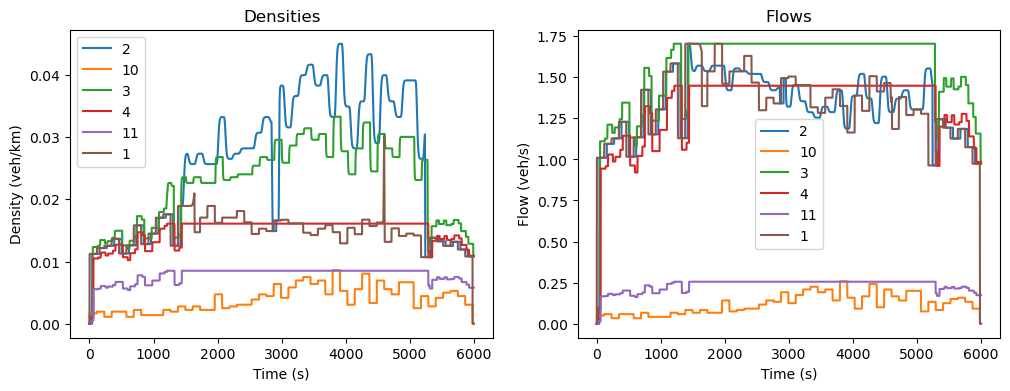

In [73]:
import pylab
run = get_network_with_demands()
run.run()

f, axs = pylab.subplots(1, 2, figsize=(12, 4))
for link in run.links:
    axs[0].plot(link.rho[0,:], label=link.link_id)
    axs[1].plot(link.qs[0,:], label=link.link_id)
axs[0].set_title("Densities")
axs[1].set_title("Flows")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Density (veh/km)")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Flow (veh/s)")
axs[0].legend()
axs[1].legend()



pylab.show()



In [ ]:
class BaseController:
    def __init__(self, link):
        self.link = link
        self.fd = TriangularFundamentalDiagram(vf=30.0, w=6.0, kj=0.1)
        self.fd2 = TriangularFundamentalDiagram(vf=30.0, w=6.0, kj=1.25*0.1)
    
    def start(self, time_step, total_time):
        pass

    def run_step(self, t):
        if t==40:
            self.link.set_switch(t, self.fd2, self.link.num_lanes)
        elif t==130:
            self.link.set_switch(t, self.fd, self.link.num_lanes)